In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.scale import FuncScale
from sklearn.decomposition import PCA

In [2]:
def feature_selection(target, dataframe, n_of_features):
    import pandas as pd
    from sklearn.feature_selection import mutual_info_regression
    from sklearn.decomposition import PCA
    import numpy as np
    df = dataframe
    X = df.drop(columns=[target])  # Features
    y = df[target]
    # Compute correlation (for regression tasks)
    correlations = X.corrwith(y).abs().sort_values(ascending=False)

    # Select top k correlated features
    top_k = n_of_features  # Adjust based on dataset
    selected_features = correlations.index[:top_k]
    X_selected = X[selected_features]
    print("Selected features:", list(selected_features))


    df2 = df[selected_features]
    # Apply PCA on the full dataset
    pca_all = PCA().fit(df)
    total_variance = np.sum(pca_all.explained_variance_ratio_)
    print(total_variance)
    # Apply PCA on the reduced dataset
    pca_selected = PCA().fit(df2)
    selected_variance = np.sum(pca_selected.explained_variance_ratio_)
    print(selected_variance)
    # Compute variance retained
    variance_retained = (selected_variance / total_variance) * 100
    print(f"Dataset variance retained: {variance_retained:.2f}%")
    return df2

In [3]:
#####################################################CLUSTERING ###########################################

def clustering(dataset, fraction):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.cluster import KMeans, DBSCAN
    from sklearn.preprocessing import StandardScaler
    from mpl_toolkits.mplot3d import Axes3D
    X = dataset.sample(frac=fraction).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels_kmeans = kmeans.fit_predict(X_scaled)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    labels_dbscan = dbscan.fit_predict(X_scaled)
    fig = plt.figure(figsize=(16, 8))

    # K-Means
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels_kmeans, cmap='viridis', alpha=0.6)
    ax1.set_xlabel('M1')
    ax1.set_ylabel('M2')
    ax1.set_zlabel('S2')
    ax1.set_title("K-Means Clustering")

    # DBSCAN
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels_dbscan, cmap='plasma', alpha=0.6)
    ax2.set_xlabel('M1')
    ax2.set_ylabel('M2')
    ax2.set_zlabel('S2')
    ax2.set_title("DBSCAN Clustering")

    plt.show()
    inertia = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    #plt.plot(range(1, 10), inertia, marker='o')
    #plt.xlabel("Number of Clusters")
    #plt.ylabel("Inertia (WCSS)")
    #plt.title("Elbow Method for K-Means")
    #plt.show()
    return


Selected features: ['M1', 'M2', 'S2']
0.9999999999999997
1.0
Dataset variance retained: 100.00%


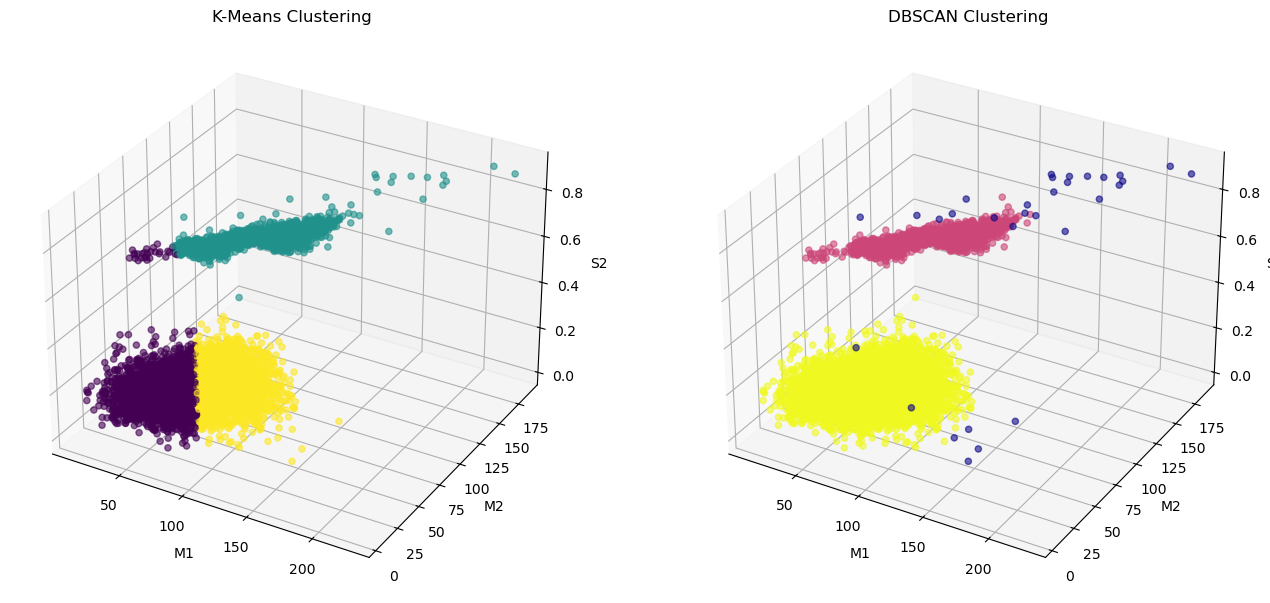

In [12]:
ysc_red = feature_selection('Mrem', pd.read_csv('ysc.csv'),3)
clustering(ysc_red, 1)

Selected features: ['M1', 'M2', 'S2']
1.0
0.9999999999999999
Dataset variance retained: 100.00%


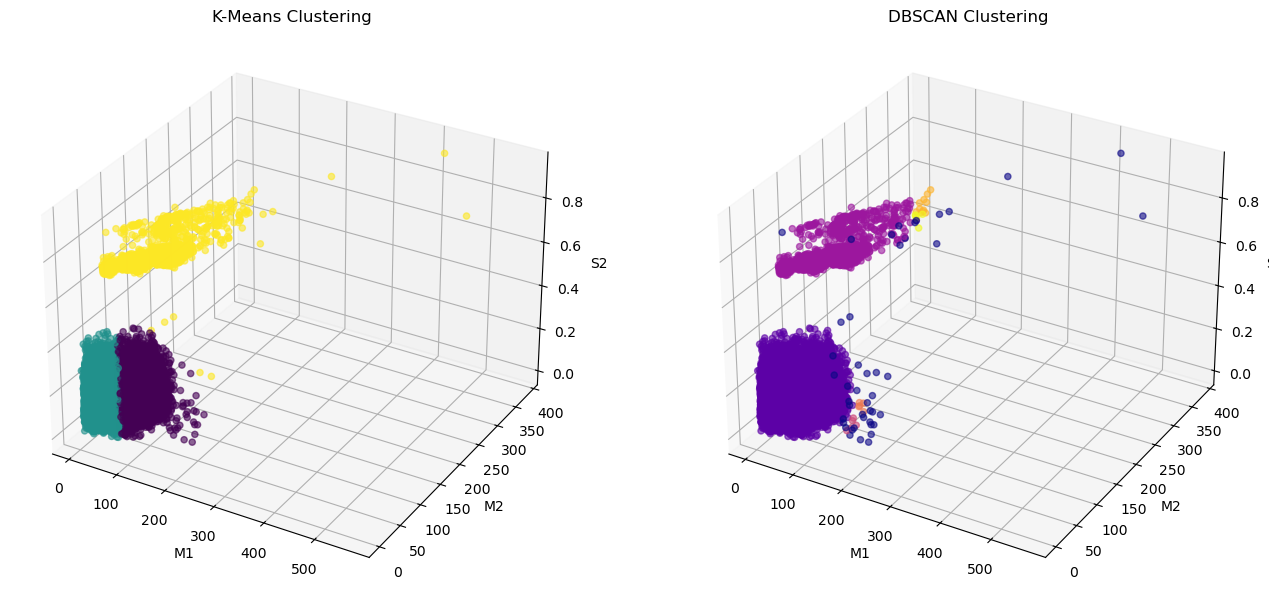

In [4]:
gc_red = feature_selection('Mrem', pd.read_csv('gc.csv'),3)
clustering(gc_red, 0.1)

Selected features: ['M1', 'M2', 'S2']
1.0
0.9999999999999999
Dataset variance retained: 100.00%


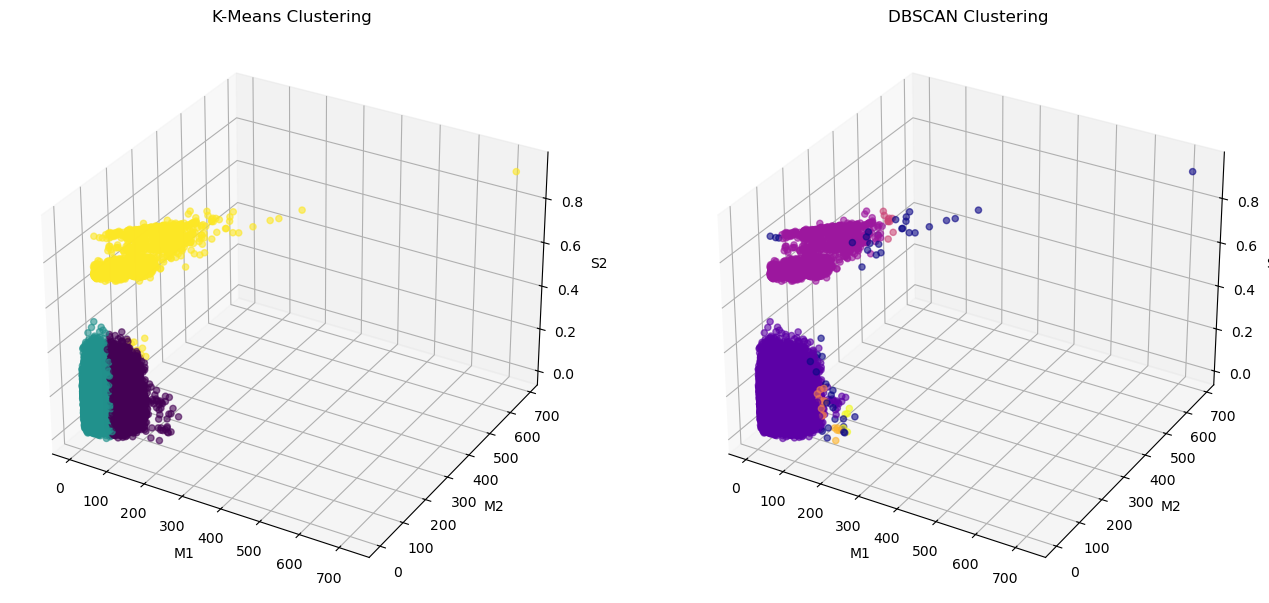

In [7]:
gc_red = feature_selection('Mrem', pd.read_csv('gc.csv'),3)
clustering(gc_red, 0.2)

Selected features: ['M1', 'M2', 'S2']
1.0
1.0
Dataset variance retained: 100.00%


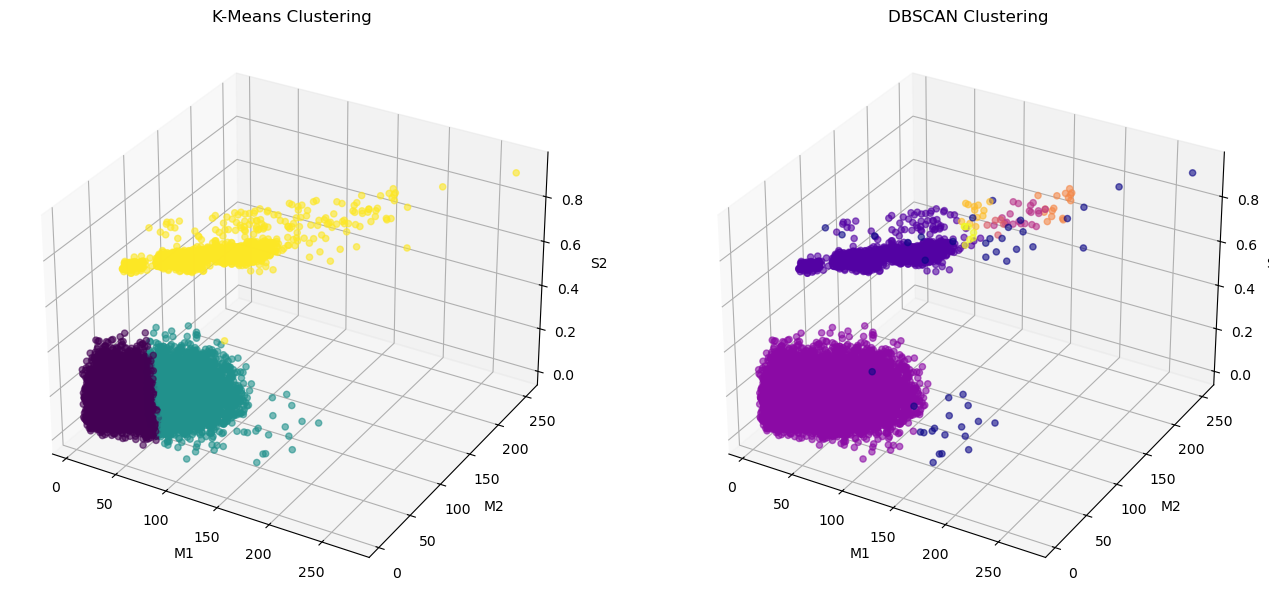

In [9]:
nsc_red = feature_selection('Mrem', pd.read_csv('nsc.csv'),3)
clustering(gc_red, 0.05)

In [43]:
df = pd.read_csv('gc.csv')
# Assume df is your dataset with a target column
X = df.drop(columns=['Mrem'])  # Features
y = df['Mrem']  # Target variable

# Compute correlation (for regression tasks)
correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Select top k correlated features
top_k = 5  # Adjust based on dataset
selected_features = correlations.index[:top_k]
X_selected = X[selected_features]
print("Selected features:", list(selected_features))

Selected features: ['M1', 'M2', 'S2', 'Srem', 't_elapsed']


In [44]:
df = pd.read_csv('nsc.csv')
# Assume df is your dataset with a target column
X = df.drop(columns=['Mrem'])  # Features
y = df['Mrem']  # Target variable

# Compute correlation (for regression tasks)
correlations = X.corrwith(y).abs().sort_values(ascending=False)

# Select top k correlated features
top_k = 5  # Adjust based on dataset
selected_features = correlations.index[:top_k]
X_selected = X[selected_features]
print("Selected features:", list(selected_features))

Selected features: ['M1', 'M2', 'S2', 'gen', 'Srem']


In [30]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sample dataset
X = data.index(False)
feature_names = list(data.columns)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (retain 90% variance)
pca = PCA(n_components=0.999)
X_pca = pca.fit_transform(X_scaled)

# Get the loading matrix
loadings = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# Print loading matrix
print("Feature Contributions to Principal Components:")
print(loadings)


TypeError: 'RangeIndex' object is not callable

In [36]:
heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = './data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,14,15,16,17,25,27]


In [37]:
def extractor(cluster, path_data=path_data):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data) #check what your pc does here
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
        data = data[data['t_elapsed'] != 136000]
    return data

In [40]:
extractor('gc').to_csv('gc.csv', index=False)

In [5]:
def rndmfrst(cluster, listwhattodrop, target, title, n_estimators=50, max_depth=20, random_state=42, n_jobs=6, cv=5):
    dataysc = extractor(cluster)
    #dataysc['DiffSpin'] = abs(dataysc.S2 - dataysc.S1)
    df = dataysc.drop(columns=listwhattodrop)
    del dataysc

    feature_names = list(df.columns)
    feature_names.remove(target)

    X = df.drop(columns=target)
    y = df[target]

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', model)])

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error),
        'rmse': make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))  # RMSE
    }

    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, return_estimator=True)

    # Compute mean and std for each metric
    print(f"Cross-Validation ({cv}-fold) Results:")
    print(f"R² Score: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
    print(f"MAE: {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")
    print(f"MSE: {cv_results['test_mse'].mean():.4f} ± {cv_results['test_mse'].std():.4f}")
    print(f"RMSE: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")

    best_estimator = cv_results['estimator'][np.argmax(cv_results['test_r2'])]  # Choose model with highest R²
    feature_importances = best_estimator.named_steps['regressor'].feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.grid(True, axis='y', linestyle="--", linewidth=0.6)
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.yscale('log')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return print(f'Feature importances: {feature_importances[sorted_idx]}')


##################### Graphs ################
def hist2dgraph( x,y, nxbin,nybin, title, axx, axy, vmin, vmax, scale='linear'):
    if scale == 'linear':
        xbin= np.linspace(x.min(),x.max(),nxbin)
        ybin= np.linspace(y.min(),y.max(),nybin)
        plt.xscale('linear')
        plt.yscale('linear')
    elif scale == 'log':
        xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)
        ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
        plt.xscale('log')
        plt.yscale('log')
    hist = plt.hist2d(x,y,bins=(xbin,ybin), cmap="Blues", norm=colors.LogNorm( vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(axx)
    plt.ylabel(axy)
    return hist

In [6]:
data = extractor('nsc')

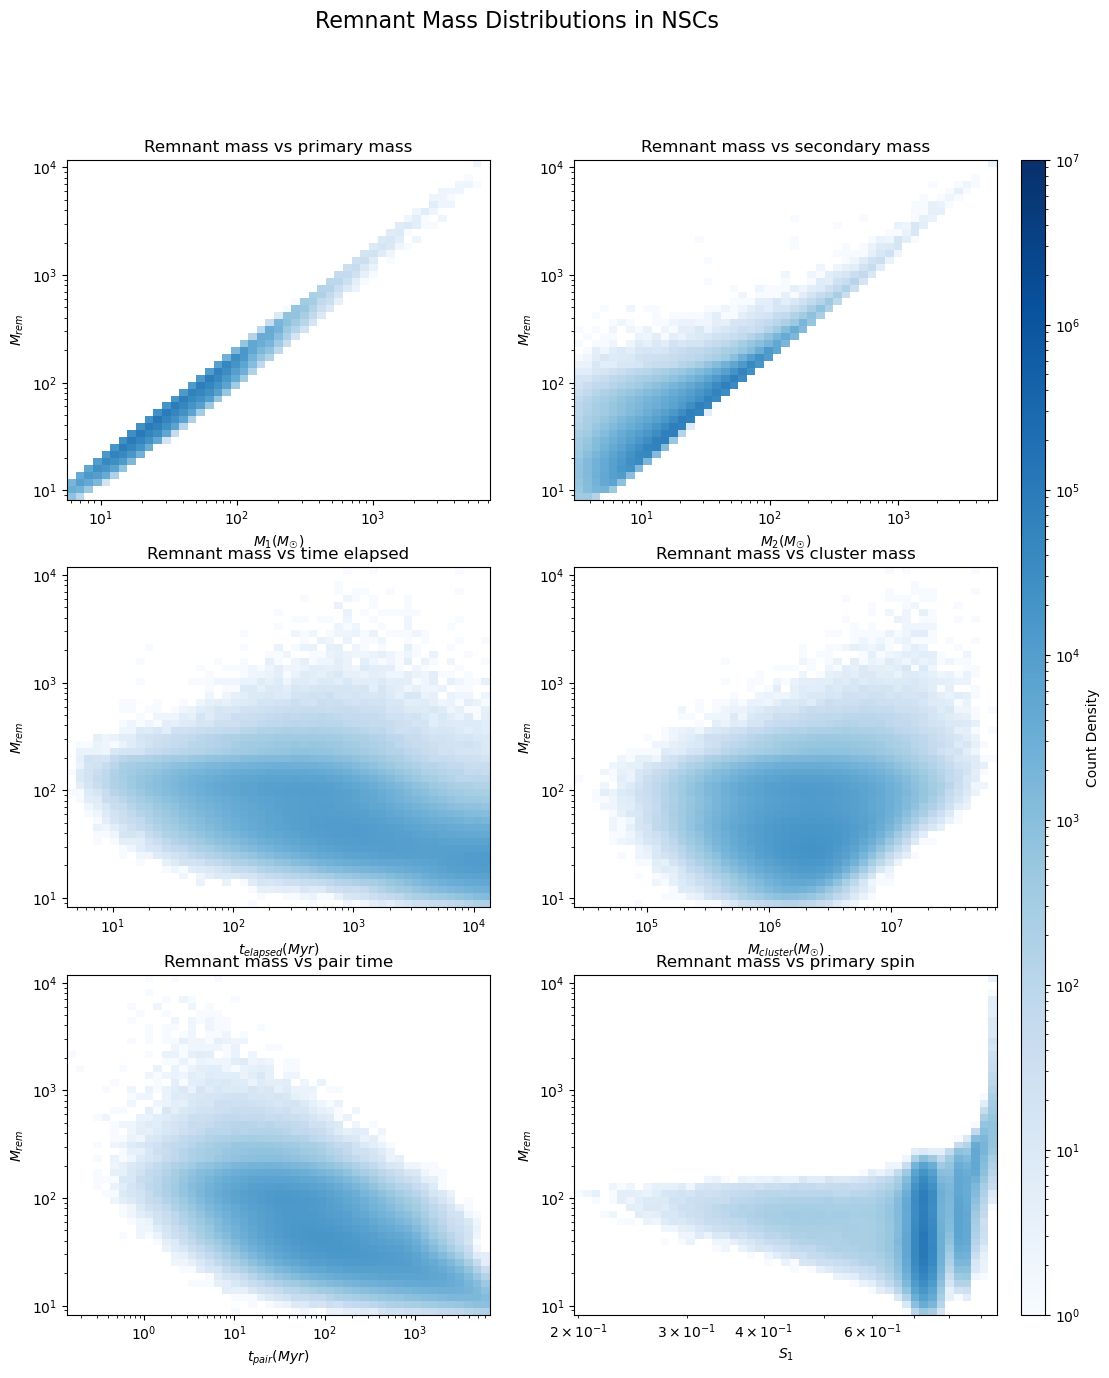

array([0.19706216, 0.20351716, 0.2101836 , 0.21706841, 0.22417874,
       0.23152198, 0.23910576, 0.24693795, 0.25502669, 0.26338039,
       0.27200772, 0.28091765, 0.29011944, 0.29962265, 0.30943714,
       0.31957311, 0.33004111, 0.34085199, 0.352017  , 0.36354773,
       0.37545616, 0.38775467, 0.40045603, 0.41357344, 0.42712052,
       0.44111136, 0.45556048, 0.4704829 , 0.48589412, 0.50181015,
       0.51824753, 0.53522334, 0.55275521, 0.57086135, 0.58956059,
       0.60887234, 0.62881667, 0.6494143 , 0.67068663, 0.69265575,
       0.71534451, 0.73877646, 0.76297595, 0.78796812, 0.81377894,
       0.84043523, 0.86796467, 0.89639588, 0.92575838, 0.95608268])

In [7]:
#data = dat
#data = data[data.M1<2000]

fig, ax = plt.subplots(3,2,figsize=(12,15))
fig.suptitle("Remnant Mass Distributions in NSCs", fontsize=16)
plt.sca(ax[0,0])
hist = hist2dgraph(data.M1,data.Mrem,50,50,'Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[0,1])

hist2 = hist2dgraph(data.M2,data.Mrem,50,50,'Remnant mass vs secondary mass',u'$M_2 (M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[1,0])
hist = hist2dgraph(data.t_elapsed,data.Mrem,50,50,'Remnant mass vs time elapsed',u'$t_{elapsed} (Myr)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[1,1])
jist3 = hist2dgraph(data.Mcluster,data.Mrem,50,50,'Remnant mass vs cluster mass',u'$M_{cluster}(M_\u2609)$', u'$M_{rem}$', 1, 1e7, 'log')
plt.sca(ax[2,0])
hist2 = hist2dgraph(data.t_pair,data.Mrem,50,50,'Remnant mass vs pair time',u'$t_{pair}(Myr)$', u'$M_{rem}$', 1, 1e7, 'log')
#plt.xticks([1,2,3,4,5,6,7])

plt.sca(ax[2,1])
hist2 = hist2dgraph(data.S1,data.Mrem,50,50,'Remnant mass vs primary spin',u'$S_1$', u'$M_{rem}$', 1, 1e7, 'log')


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # Adjust position [left, bottom, width, height]
fig.colorbar(hist[3], cax=cbar_ax, label="Count Density")
plt.show()




hist2[1]


### Random Forest Classifier

In [9]:
import pandas as pd

# step 1 bin the target col
data = pd.read_csv('nsc.csv')
#data['Rembin'] = pd.cut(data['Mrem'], bins=7, labels=False)
data = data[data.gen>2]
data = data[data.gen < 13]

expected_classes = [0, 1, 2, 3]
remap_dict = {3: 0, 4: 1, 5: 2, 6: 3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9}
data = data.drop(columns=['kick', 'Mrem', 'Srem','esca_v','Mcluster'])

In [10]:
data.head()

,M1,M2,S1,S2,t_pair,t_elapsed,gen,Z
244404,153.864399,80.363555,0.883365,0.814739,24.208906,131.226646,3,0.0002
244405,55.556080,45.133478,0.846194,0.139241,24.705624,393.218863,3,0.0002
244406,29.872870,25.827441,0.838479,0.127683,184.009305,9996.666356,3,0.0002
244407,202.270870,40.695842,0.885660,0.125281,1.838430,81.648692,3,0.0002
244408,181.937573,181.195182,0.894685,0.847604,26.202767,492.967360,3,0.0002


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
y = data['gen']
y = y.map(remap_dict).astype(int)
X = data.drop(columns='gen')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X.columns

Index(['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed', 'Z'], dtype='object')

In [13]:
model = xgb.XGBClassifier(
    n_estimators=100,        # Number of trees
    max_depth=6,             # Maximum depth of a tree
    learning_rate=0.1,       # Step size shrinkage
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns when constructing each tree
    random_state=42,         # Random seed
    #use_label_encoder=False,
    nthread=5# Disable label encoder (not needed for newer versions)
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


Confusion Matrix:
[[36134    61     1     0     0     0     0     0     0]
 [  502  3783    19     0     0     0     0     0     0]
 [   10   166   638    24     1     0     0     0     0]
 [    0     4    64   174    16     0     0     0     0]
 [    0     1     2    35    32     7     0     0     0]
 [    0     0     0     2    13     6     3     0     0]
 [    0     0     0     1     1     4     2     2     1]
 [    0     0     0     0     0     1     2     2     2]
 [    0     0     0     0     0     0     0     2     0]]


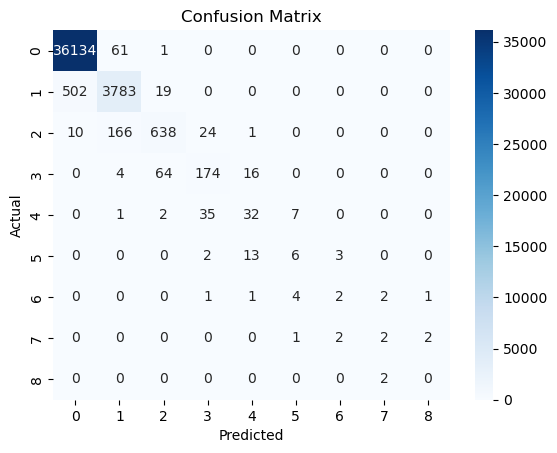

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     36196
           1       0.94      0.88      0.91      4304
           2       0.88      0.76      0.82       839
           3       0.74      0.67      0.70       258
           4       0.51      0.42      0.46        77
           5       0.33      0.25      0.29        24
           6       0.29      0.18      0.22        11
           7       0.33      0.29      0.31         7
           8       0.00      0.00      0.00         2

    accuracy                           0.98     41718
   macro avg       0.56      0.49      0.52     41718
weighted avg       0.98      0.98      0.98     41718



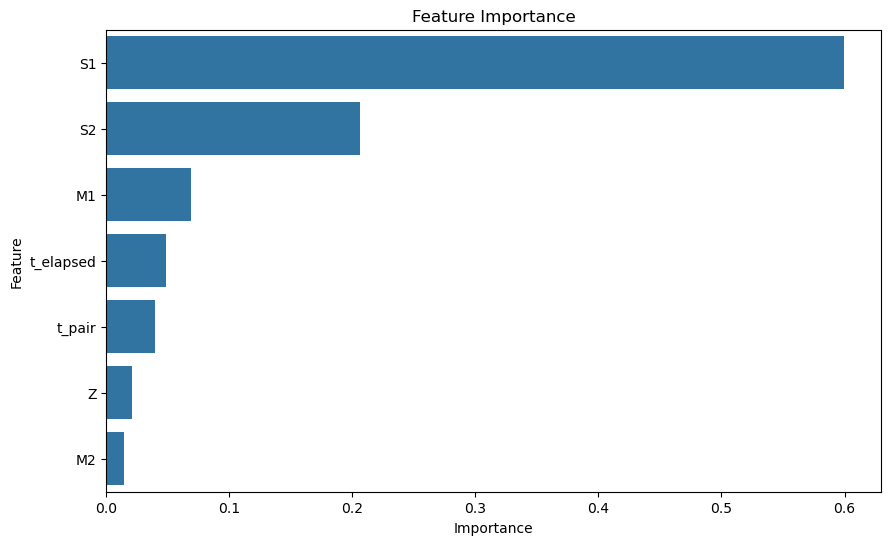

In [14]:


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Feature Importance
feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# ROC Curve (for binary classification)
if len(y.unique()) == 2:
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [15]:
import numpy as np

In [25]:
GEN = [model.predict(pd.DataFrame([Z, M2, t_elapsed, M1, S1, t_pair, S2], index=False))
       for M1 in np.arange(1,3000,1)
       for M2 in np.arange(1,2800,1)
       for S1 in np.arange(0,1,0.01)
       for S2 in np.arange(0,1,0.01)
       for t_elapsed in np.arange(1,13600,1)
       for t_pair in np.arange(1,6500,1)
       for Z in np.arange(0,0.2,0.001)]

TypeError: Index(...) must be called with a collection of some kind, False was passed